In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
import gc
from tqdm.notebook import tqdm
import zipfile

In [ ]:
MASKS = '../input/hubmap-kidney-segmentation/train.csv'
DATA = '../input/hubmap-kidney-segmentation/train/'
OUT_TRAIN1 = 'train1.zip'
OUT_MASKS1 = 'masks1.zip'
OUT_TRAIN2 = 'train2.zip'
OUT_MASKS2 = 'masks2.zip'

In [ ]:
df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

In [ ]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def findpad(dim,crop_size):
    """
    takes input dimension of image and returns the dimension to be padded
    """
    out = []
    for i in dim:
        reminder = i%crop_size   #eg 1100%512= 76
        if reminder > 0:
            pad = crop_size - reminder  # pad = 512-76 = 436
        else:
            pad = 0  #if reminder = 0 no padding is required
        out.append(pad)
        
    return out[0],out[1]

def dopadding(img,crop_size=1024,img_type='image'):
    """
    find the padding size and do padding using np.pad on both y and x direction
    crop_size: window/kernel size which is planned to use
    """
    pad0,pad1 = findpad([img.shape[0],img.shape[1]],crop_size)
    # img,y_padding,x_padding,color,filling value
    if img_type=='image':
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],constant_values=0)
    else:
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],constant_values=0)
        
    return img

# pad_img = dopadding(img,crop_size=WINDOW)
# pad_img = cv2.resize(pad_img,(pad_img.shape[1]//reduce, pad_img.shape[0]//reduce), interpolation=cv2.INTER_AREA)
# WINDOW = WINDOW/reduce



def make_inter_grid(img_shape,WINDOW=256):
    """
    input: padded_image_dimension
    """

    y,x = img_shape[0],img_shape[1]
    start = int(WINDOW/2)
    end_x = x - start
    end_y = y - start
    ny,nx = int(end_y/WINDOW),int(end_x/WINDOW)
    base_y = np.linspace(start,end_y,ny+1,dtype=np.int64)
    base_x = np.linspace(start,end_x,nx+1,dtype=np.int64)
    
    y1,y2 = base_y[0:-1],base_y[1:]
    x1,x2 = base_x[0:-1],base_x[1:]
    slices = np.zeros(shape=(len(x1),len(y1),4),dtype=np.int64)
    for i in range(len(x1)):
        for j in range(len(y1)):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    slices = slices.reshape(len(x1) * len(y1), 4)
    return slices


def make_normal_grid(img_shape,WINDOW=256):
    #padding
    y,x = img_shape[0],img_shape[1]
    nx,ny = int(x/WINDOW), int(y/WINDOW)

    base_y = np.linspace(0,y,ny+1,dtype=np.int64)
    base_x = np.linspace(0,x,nx+1,dtype=np.int64)
    y1,y2 = base_y[0:-1],base_y[1:]
    x1,x2 = base_x[0:-1],base_x[1:]
    slices = np.zeros(shape=(len(x1),len(y1),4),dtype=np.int64)
    for i in range(len(x1)):
        for j in range(len(y1)):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    slices = slices.reshape(len(x1) * len(y1), 4)
    return slices

### Dataset 1 [Green box]

Slides without overlaping

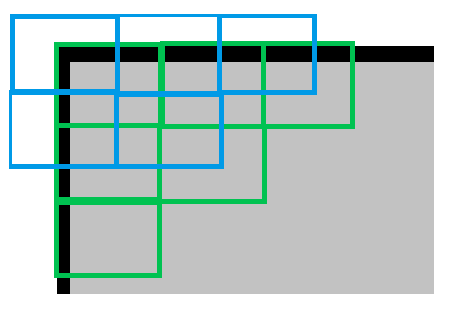

In [ ]:
WINDOW = 1024
reduce = 4
s_th = 40  #saturation blancking threshold
sz=256
p_th = 200*sz//256 #threshold for the minimum number of pixels

with zipfile.ZipFile(OUT_TRAIN1, 'w') as img_out,zipfile.ZipFile(OUT_MASKS1, 'w') as mask_out:

    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5: 
            img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))
        print(f'processing image and mask of shapes: {img.shape},{mask.shape}')
        #padding images/masks
        pad_img = dopadding(img,crop_size=WINDOW,img_type='image')
        pad_mask = dopadding(mask,crop_size=WINDOW,img_type='mask')
        # downsizing whole image by reduce_factor
        img = cv2.resize(pad_img,(pad_img.shape[1]//reduce, pad_img.shape[0]//reduce), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(pad_mask,(pad_img.shape[1]//reduce, pad_img.shape[0]//reduce), interpolation = cv2.INTER_NEAREST)
        # generating grids for saving
        reduced_window_size = int(WINDOW/reduce)
        slices = make_normal_grid(img.shape,WINDOW=reduced_window_size)
        for i,(x1,x2,y1,y2) in enumerate(tqdm(slices,desc=f'{len(slices)}')):
            img_crop = img[y1:y2,x1:x2]
            mask_crop = mask[y1:y2,x1:x2]
            
            #remove black or gray images based on saturation check
            hsv = cv2.cvtColor(img_crop, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            # if gray image continue to next pair of image/mask
            if (s>s_th).sum() <= p_th or img_crop.sum() <= p_th: 
                    continue
            
            img_crop = cv2.cvtColor(img_crop, cv2.COLOR_RGB2BGR)
        
            im = cv2.imencode('.png',img_crop)[1]
            img_out.writestr(f'{index}_{i}.png', im)
            m = cv2.imencode('.png',mask_crop)[1]
            mask_out.writestr(f'{index}_{i}.png', m)
            gc.collect()
            
 
gc.collect()   

In [ ]:


columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN1, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS1, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()



### Dataset2 [blue box]

Overlaping slide covering 4 slides as given below:


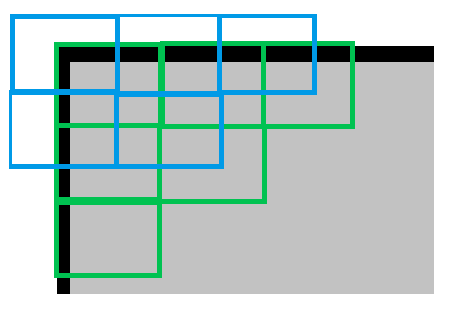

In [ ]:
WINDOW = 1024
reduce = 4
s_th = 40  #saturation blancking threshold
sz=256
p_th = 200*sz//256 #threshold for the minimum number of pixels

with zipfile.ZipFile(OUT_TRAIN2, 'w') as img_out,zipfile.ZipFile(OUT_MASKS2, 'w') as mask_out:

    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5: 
            img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))
        print(f'processing image and mask of shapes: {img.shape}, {mask.shape}')
        #padding images/masks
        pad_img = dopadding(img,crop_size=WINDOW,img_type='image')
        pad_mask = dopadding(mask,crop_size=WINDOW,img_type='mask')
        # downsizing whole image by reduce_factor
        img = cv2.resize(pad_img,(pad_img.shape[1]//reduce, pad_img.shape[0]//reduce), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(pad_mask,(pad_img.shape[1]//reduce, pad_img.shape[0]//reduce), interpolation=cv2.INTER_AREA)
        # generating grids for saving
        reduced_window_size = int(WINDOW/reduce)
        slices = make_inter_grid(img.shape,WINDOW=reduced_window_size)
        for i,(x1,x2,y1,y2) in enumerate(tqdm(slices,desc=f'{len(slices)}')):
            img_crop = img[y1:y2,x1:x2]
            mask_crop = mask[y1:y2,x1:x2]
        
            #remove black or gray images based on saturation check
            hsv = cv2.cvtColor(img_crop, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            # if gray image continue to next pair of image/mask
            if (s>s_th).sum() <= p_th or img_crop.sum() <= p_th: 
                    continue  
            img_crop = cv2.cvtColor(img_crop, cv2.COLOR_RGB2BGR)
            
            im = cv2.imencode('_inter.png',img_crop)[1]
            img_out.writestr(f'{index}_inter_{i}.png', im)
            m = cv2.imencode('_inter.png',mask_crop)[1]
            mask_out.writestr(f'{index}_inter_{i}.png', m)
            gc.collect()
            
    

In [ ]:


columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN2, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS2, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

